In [12]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import random
import os

In [ ]:
def set_seeds(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    # Chế độ deterministic cho TensorFlow
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

set_seeds(42)

In [ ]:
spark = SparkSession.builder \
            .appName("VBMA SVR") \
            .config("spark.sql.catalog.nessie.ref", "feature/fact-macro-build") \
            .getOrCreate()

### Load data from Gold layer

In [ ]:
dim_time = spark.read.format("iceberg").load("nessie.gold.dim_time")
dim_industry = spark.read.format("iceberg").load("nessie.gold.dim_industry")
dim_indicator = spark.read.format("iceberg").load("nessie.gold.dim_indicator")
fact_df = spark.read.format("iceberg").load("nessie.gold.fact_macro")

In [ ]:
fact_df.show()

+--------------------+--------+--------------------+--------------------+-----------+
|       fact_macro_id|time_key|        industry_key|       indicator_key|      value|
+--------------------+--------+--------------------+--------------------+-----------+
|a4c6f34b-e138-4a3...|20201201|689b90de-67b7-4b5...|f4cc28d4-367c-44d...|        1.0|
|9b0b0283-323f-42e...|20201201|e7ccfbc9-4e96-403...|f4cc28d4-367c-44d...|        1.0|
|76d6e250-fbe2-409...|20201201|d1dfc9de-9dd0-4e6...|f4cc28d4-367c-44d...|        1.0|
|072e823c-0b88-4a8...|20201201|4f31c579-5443-46f...|f4cc28d4-367c-44d...|        1.0|
|97b5c2a7-10e0-4ce...|20210101|689b90de-67b7-4b5...|f4cc28d4-367c-44d...|     1.0064|
|37d39266-3401-4c0...|20210101|e7ccfbc9-4e96-403...|f4cc28d4-367c-44d...|     0.9769|
|055c89d3-45c8-4be...|20210101|d1dfc9de-9dd0-4e6...|f4cc28d4-367c-44d...|        1.0|
|71ec7976-4cc4-4db...|20210101|4f31c579-5443-46f...|f4cc28d4-367c-44d...|     1.0229|
|72078f4f-03f9-47a...|20210201|689b90de-67b7-4b5...|f4

### Prepare data for training

In [19]:
macro_df = fact_df \
    .join(dim_time, fact_df.time_key == dim_time.time_key, "inner")
macro_df = macro_df \
    .join(dim_industry, macro_df.industry_key == dim_industry.industry_key, "inner")
macro_df = macro_df \
    .join(dim_indicator, macro_df.indicator_key == dim_indicator.indicator_key, "inner")

macro_df = macro_df.select(
    'full_date',
    'industry',
    'indicator_code',
    'value'
)

macro_df.show()

+----------+---------------+--------------+-----------+
| full_date|       industry|indicator_code|      value|
+----------+---------------+--------------+-----------+
|2020-12-01|      Thực phẩm|           CPI|        1.0|
|2020-12-01|Nhà, điện, nước|           CPI|        1.0|
|2020-12-01|           Y tế|           CPI|        1.0|
|2020-12-01|        Vận tải|           CPI|        1.0|
|2021-01-01|      Thực phẩm|           CPI|     1.0064|
|2021-01-01|Nhà, điện, nước|           CPI|     0.9769|
|2021-01-01|           Y tế|           CPI|        1.0|
|2021-01-01|        Vận tải|           CPI|     1.0229|
|2021-02-01|      Thực phẩm|           CPI| 1.02260304|
|2021-02-01|Nhà, điện, nước|           CPI|   1.015976|
|2021-02-01|           Y tế|           CPI|        1.0|
|2021-02-01|        Vận tải|           CPI| 1.03875495|
|2021-03-01|      Thực phẩm|           CPI|1.007673036|
|2021-03-01|Nhà, điện, nước|           CPI|1.018414342|
|2021-03-01|           Y tế|           CPI|     

In [20]:
# Get average value by indicator_code and full_date
macro_df = macro_df.groupBy('indicator_code', 'full_date').agg(F.avg('value').alias('avg_value'))
macro_df.show()

+--------------+----------+------------------+
|indicator_code| full_date|         avg_value|
+--------------+----------+------------------+
|           CPI|2022-08-01|1.0794998902500001|
|           CPI|2021-12-01|     1.04347009475|
|           CPI|2022-03-01|       1.077647437|
|           CPI|2022-10-01|1.0714214682499998|
|           CPI|2021-08-01|     1.04249517475|
|           CPI|2022-01-01|      1.0470634925|
|           CPI|2022-04-01|      1.0771678795|
|           CPI|2021-11-01|     1.04919780025|
|           CPI|2021-03-01|1.0221824539999997|
|           CPI|2021-02-01|      1.0193334975|
|           CPI|2021-10-01|      1.0395780225|
|           CPI|2021-06-01|     1.03041237675|
|           CPI|2021-05-01|      1.0262222605|
|           CPI|2022-02-01|      1.0601428505|
|           CPI|2022-11-01|1.0803056205000001|
|           CPI|2021-04-01|       1.023071195|
|           CPI|2021-01-01|           1.00155|
|           CPI|2022-07-01|      1.0937919875|
|           C

In [21]:
macro_df.select('indicator_code').distinct().show(truncate=False)

+---------------------+
|indicator_code       |
+---------------------+
|CPI                  |
|GDP_NOMINAL          |
|GDP_REAL             |
|INFLATION_BY_INDUSTRY|
|GDP_GROWTH_RATE      |
|GDP_REAL_GROWTH_RATE |
+---------------------+



In [22]:
# macro_df = macro_df.filter(F.col('indicator_code').isin(['CPI', 'INFLATION_BY_INDUSTRY', 'GDP_REAL']))
macro_df = macro_df.filter(F.col('indicator_code') == 'CPI')  
macro_df.show()

+--------------+----------+------------------+
|indicator_code| full_date|         avg_value|
+--------------+----------+------------------+
|           CPI|2022-08-01|1.0794998902500001|
|           CPI|2021-12-01|     1.04347009475|
|           CPI|2022-03-01|       1.077647437|
|           CPI|2022-10-01|1.0714214682499998|
|           CPI|2021-08-01|     1.04249517475|
|           CPI|2022-01-01|      1.0470634925|
|           CPI|2022-04-01|      1.0771678795|
|           CPI|2021-11-01|     1.04919780025|
|           CPI|2021-03-01|1.0221824539999997|
|           CPI|2021-02-01|      1.0193334975|
|           CPI|2021-10-01|      1.0395780225|
|           CPI|2021-06-01|     1.03041237675|
|           CPI|2021-05-01|      1.0262222605|
|           CPI|2022-02-01|      1.0601428505|
|           CPI|2022-11-01|1.0803056205000001|
|           CPI|2021-04-01|       1.023071195|
|           CPI|2021-01-01|           1.00155|
|           CPI|2022-07-01|      1.0937919875|
|           C

In [23]:
# pivot the table to wide format
macro_df = macro_df.groupBy('full_date').pivot('indicator_code').agg(F.first('avg_value'))
macro_df = macro_df.withColumnRenamed('CPI', 'value')
macro_df.show()

+----------+------------------+
| full_date|             value|
+----------+------------------+
|2025-02-01|      1.2097850875|
|2023-01-01|      1.0800957235|
|2024-12-01|     1.16213789725|
|2022-05-01|     1.08482567475|
|2023-06-01|1.0844446104999999|
|2021-11-01|     1.04919780025|
|2022-02-01|      1.0601428505|
|2024-08-01|     1.14994829575|
|2021-06-01|     1.03041237675|
|2022-11-01|1.0803056205000001|
|2023-04-01|      1.0878100895|
|2022-07-01|      1.0937919875|
|2024-09-01|        1.14579352|
|2021-12-01|     1.04347009475|
|2021-08-01|     1.04249517475|
|2025-10-01|      1.2209062215|
|2023-02-01|      1.0907341155|
|2023-09-01|       1.112547039|
|2024-10-01|     1.14959971775|
|2021-02-01|      1.0193334975|
+----------+------------------+
only showing top 20 rows



In [24]:
macro_df = macro_df.sort('full_date')
macro_df.show(50)

+----------+------------------+
| full_date|             value|
+----------+------------------+
|2020-12-01|               1.0|
|2021-01-01|           1.00155|
|2021-02-01|      1.0193334975|
|2021-03-01|1.0221824539999997|
|2021-04-01|       1.023071195|
|2021-05-01|      1.0262222605|
|2021-06-01|     1.03041237675|
|2021-07-01|1.0407902039999999|
|2021-08-01|     1.04249517475|
|2021-09-01|1.0364989042500001|
|2021-10-01|      1.0395780225|
|2021-11-01|     1.04919780025|
|2021-12-01|     1.04347009475|
|2022-01-01|      1.0470634925|
|2022-02-01|      1.0601428505|
|2022-03-01|       1.077647437|
|2022-04-01|      1.0771678795|
|2022-05-01|     1.08482567475|
|2022-06-01|     1.09843739675|
|2022-07-01|      1.0937919875|
|2022-08-01|1.0794998902500001|
|2022-09-01|      1.0756803865|
|2022-10-01|1.0714214682499998|
|2022-11-01|1.0803056205000001|
|2022-12-01|     1.07420989325|
|2023-01-01|      1.0800957235|
|2023-02-01|      1.0907341155|
|2023-03-01|     1.08981735075|
|2023-04

In [25]:
macro_pd = macro_df.toPandas()
macro_pd

,full_date,value
0,2020-12-01,1.000000
1,2021-01-01,1.001550
2,2021-02-01,1.019333
3,2021-03-01,1.022182
4,2021-04-01,1.023071
5,2021-05-01,1.026222
6,2021-06-01,1.030412
7,2021-07-01,1.040790
8,2021-08-01,1.042495
9,2021-09-01,1.036499


In [26]:
# Chuẩn hoá 2 bước (Z-score + MinMax)
scaler_z = StandardScaler()
scaler_mm = MinMaxScaler()
macro_pd['value_norm'] = scaler_mm.fit_transform(
    scaler_z.fit_transform(macro_pd[['value']])
)

In [27]:
# Hàm tạo tập dữ liệu
def make_supervised(df, col='value', window=12):
    data = df[col].values
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i + window])
        y.append(data[i + window])
    return np.array(X), np.array(y)

In [29]:
# Tạo tập dữ liệu
window = 10
X, y = make_supervised(macro_pd, col='value_norm', window=window)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [31]:
X_train

array([[0.        , 0.0069971 , 0.08727643, 0.10013735, 0.10414936,
        0.11837409, 0.13728936, 0.18413757, 0.19183425, 0.16476553],
       [0.0069971 , 0.08727643, 0.10013735, 0.10414936, 0.11837409,
        0.13728936, 0.18413757, 0.19183425, 0.16476553, 0.17866547],
       [0.08727643, 0.10013735, 0.10414936, 0.11837409, 0.13728936,
        0.18413757, 0.19183425, 0.16476553, 0.17866547, 0.22209164],
       [0.10013735, 0.10414936, 0.11837409, 0.13728936, 0.18413757,
        0.19183425, 0.16476553, 0.17866547, 0.22209164, 0.19623529],
       [0.10414936, 0.11837409, 0.13728936, 0.18413757, 0.19183425,
        0.16476553, 0.17866547, 0.22209164, 0.19623529, 0.21245682],
       [0.11837409, 0.13728936, 0.18413757, 0.19183425, 0.16476553,
        0.17866547, 0.22209164, 0.19623529, 0.21245682, 0.27150044],
       [0.13728936, 0.18413757, 0.19183425, 0.16476553, 0.17866547,
        0.22209164, 0.19623529, 0.21245682, 0.27150044, 0.35052068],
       [0.18413757, 0.19183425, 0.1647655

In [39]:
y_train

array([0.17866547, 0.22209164, 0.19623529, 0.21245682, 0.27150044,
       0.35052068, 0.34835584, 0.38292511, 0.44437196, 0.42340137,
       0.35888314, 0.34164091, 0.32241504, 0.36252041, 0.33500272,
       0.36157288, 0.40959735, 0.40545883, 0.39639753, 0.37141595,
       0.38120489, 0.39699148, 0.46787456, 0.50806655, 0.49138804,
       0.53598198, 0.549981  , 0.58101659, 0.64924196, 0.64303753,
       0.68584819, 0.67122331, 0.66311985, 0.69428147, 0.67690553,
       0.65814979, 0.67533195, 0.68336446, 0.73193255])

In [32]:
# Huấn luyện nhiều SVR với các kernel khác nhau
kernels = ['linear', 'poly', 'rbf']
preds = []

for kernel in kernels:
    print(f"Training SVR with kernel = {kernel}")
    model = SVR(kernel=kernel, C=1.0, epsilon=0.01)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    preds.append(y_pred)

Training SVR with kernel = linear
Training SVR with kernel = poly
Training SVR with kernel = rbf


In [33]:
# Tính trọng số theo KKT có regularization λ ===
def kkt_weights(F, Y, lam=1e-3, non_negative=True):
    A = F.T @ F + lam * np.eye(F.shape[1])
    b = F.T @ Y
    ones = np.ones(A.shape[0])
    A_aug = np.block([[2*A, ones[:, None]], [ones[None, :], 0]])
    rhs = np.concatenate([2*b, [1]])
    sol = np.linalg.solve(A_aug, rhs)
    a_opt = sol[:-1]
    if non_negative:
        a_opt[a_opt < 0] = 0
        a_opt /= a_opt.sum()
    return a_opt

In [34]:
# Áp dụng KKT để tìm trọng số tối ưu
F = np.vstack(preds).T
Y = y_test
a_opt = kkt_weights(F, Y, lam=1e-3)
Y_pred_ens = F @ a_opt

In [36]:
# Hàm đánh giá hiệu xuất
def evaluate(Y_true, Y_pred):
    mse = mean_squared_error(Y_true, Y_pred)
    mae = mean_absolute_error(Y_true, Y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(Y_true, Y_pred)
    return mse, mae, rmse, r2

In [37]:
# In kết quả
print("\nENSEMBLE SVR (KKT + λ)")
for i, k in enumerate(kernels):
    mse_i, mae_i, rmse_i, r2_i = evaluate(Y, F[:, i])
    print(f"\n[{k.upper()}]")
    print(f"MSE  = {mse_i:.6f}")
    print(f"MAE  = {mae_i:.6f}")
    print(f"RMSE = {rmse_i:.6f}")
    print(f"R²   = {r2_i:.6f}")

mse_ens, mae_ens, rmse_ens, r2_ens = evaluate(Y, Y_pred_ens)
print("\n=== ENSEMBLE (KKT + λ) ===")
print(f"Optimal weights (sum={a_opt.sum():.4f}): {np.round(a_opt, 4)}")
print(f"MSE  = {mse_ens:.6f}")
print(f"MAE  = {mae_ens:.6f}")
print(f"RMSE = {rmse_ens:.6f}")
print(f"R²   = {r2_ens:.6f}")


ENSEMBLE SVR (KKT + λ)

[LINEAR]
MSE  = 0.004947
MAE  = 0.043266
RMSE = 0.070336
R²   = -5.352323

[POLY]
MSE  = 0.368480
MAE  = 0.548096
RMSE = 0.607026
R²   = -472.144789

[RBF]
MSE  = 0.192521
MAE  = 0.424755
RMSE = 0.438772
R²   = -246.205452

=== ENSEMBLE (KKT + λ) ===
Optimal weights (sum=1.0000): [0.9612 0.0359 0.0029]
MSE  = 0.004497
MAE  = 0.043972
RMSE = 0.067062
R²   = -4.774825


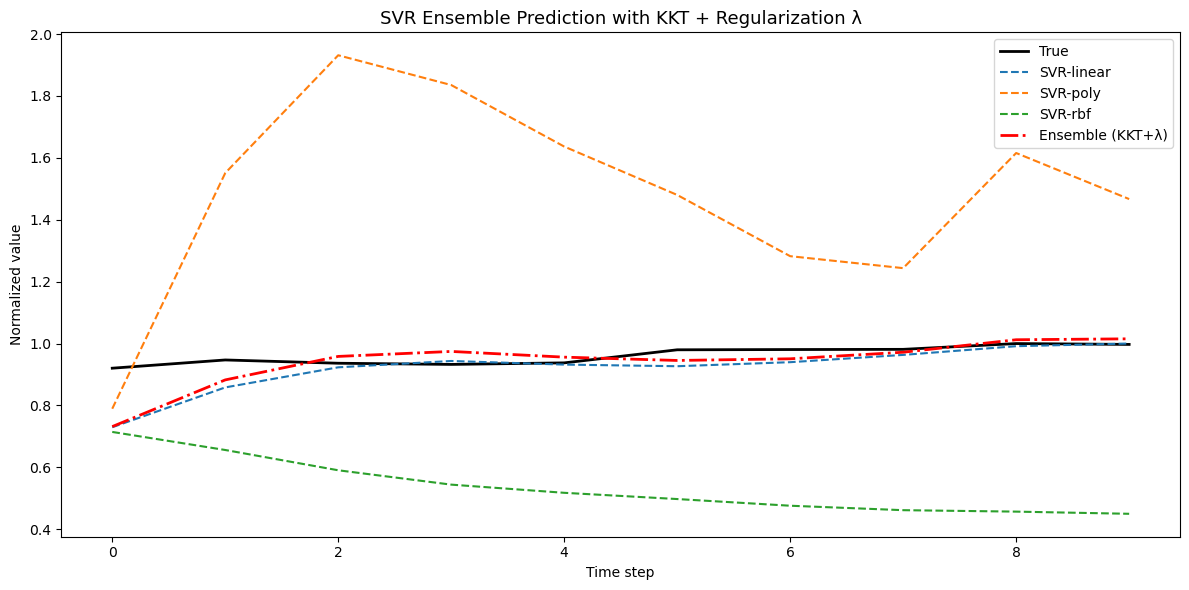

In [38]:
# Hiển thị biểu đồ
plt.figure(figsize=(12, 6))
plt.plot(Y, label='True', color='black', linewidth=2)
for i, (y_pred, name) in enumerate(zip(preds, kernels)):
    plt.plot(y_pred, '--', label=f'SVR-{name}')
plt.plot(Y_pred_ens, '-.', color='red', linewidth=2, label='Ensemble (KKT+λ)')
plt.title("SVR Ensemble Prediction with KKT + Regularization λ", fontsize=13)
plt.xlabel("Time step")
plt.ylabel("Normalized value")
plt.legend()
plt.tight_layout()
plt.show()